Deadline: 23:59 on 2021 October 18

# TODO

* Prepare data
    * Images to tensors
    * Bounding box infomration to numpy array
* Implement two different models
    * Representation of the images as training input
    * Representation of the bounding boxes as objective
        * HINT: the binary classification of pixels as belonging to a bounding box or not
* Test and evaluate
    * Way 1: choose a probability threshold to decide whether a pixel is inside the bounding box or not, and then take recall/precision/X11/accuracy
    * Way 2: report it in terms of error, such as mean squared error


# Part 1 - Data preparation

1. Retrieve file names of all included images
2. Extract images data from jsonl file
3. Compile polygon list for each image

In [2]:
import jsonlines
import numpy as np
import matplotlib.path as mplpath
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split


SOURCE_DIR = "/scratch/lt2326-h21/a1/"
IMAGE_DIR = "/scratch/lt2326-h21/a1/images/"

SCALE = 0.1
IMG_SIZE_ORIG = 2048
IMG_SIZE_SCALED = int(IMG_SIZE_ORIG*SCALE)

In [3]:
# Retrieve file names of all included images
image_files = [f for f in listdir(IMAGE_DIR) if isfile(join(IMAGE_DIR, f))]
image_files = image_files[:10]

In [4]:
# Extract images data from jsonl file
def get_image_jsonl_data(jsonl_file, included_file_names):
   data = []
   with jsonlines.open(jsonl_file) as reader:
      for line in reader.iter(type=dict):
         if (line.get('file_name') in included_file_names):
            data.append(line)

   return data

# Compile polygon list for each image
def get_image_polygon_data(image_jsonl_data):
    image_polygon_data = []
    for entry in image_jsonl_data:
        image_dict = {
            'file_name': entry['file_name'],
            'size': entry['height'],
            'polygons': []
            }
        for sentence in entry['annotations']:
            for char in sentence:
                if(char['is_chinese']):
                    image_dict['polygons'].append(np.array(char['polygon']))
        image_polygon_data.append(image_dict)
    return image_polygon_data

In [5]:
image_jsonl_data = get_image_jsonl_data(SOURCE_DIR + "train.jsonl", image_files)
training_data_jsonl, testing_data_jsonl = train_test_split(image_jsonl_data, test_size=0.30)
training_data = get_image_polygon_data(training_data_jsonl)
testing_data = get_image_polygon_data(testing_data_jsonl)

In [6]:
def coordinates_grid(height, width):
    rows = np.arange(height)
    cols = np.arange(width)
    grid = np.empty((height, width, 2), dtype=np.intp)
    grid[..., 0] = rows[:, None]
    grid[..., 1] = cols
    grid = np.rot90(np.fliplr(grid))
    grid = grid.reshape(height*width, 2)
    return grid

def scale_points(points, scale):
    center = (points.min(axis=0) + points.max(axis=0)) * 0.5
    scaled_points = center * scale + points * scale
    return scaled_points

def get_ground_truth_grid(image_data, grid, size):
    truth_grid = np.zeros((size, size), dtype=np.intp)
    scale = size / image_data['size']

    for polygon in image_data['polygons']:
        if scale != 1:
            polygon = scale_points(polygon, scale)
        path = mplpath.Path(polygon)
        polygon_grid = np.asarray(path.contains_points(grid), int)
        polygon_grid.shape = (size, size)
        truth_grid += polygon_grid
    
    return truth_grid

def get_ground_truth_dict(polygon_data):
    size = IMG_SIZE_ORIG
    coords_grid = coordinates_grid(size,size)
    gt_dict = {}
    for img in polygon_data:
        gtg = get_ground_truth_grid(img, coords_grid, size)
        gt_dict[img['file_name']] = gtg
    return gt_dict

In [7]:
training_gts = get_ground_truth_dict(training_data)
testing_gts = get_ground_truth_dict(testing_data)

## Nice to have, plot images with overlay

In [29]:
import matplotlib.pyplot as mplplot
%matplotlib inline

def plot_char_detection_overlay(img_data, overlay):
    img = mplplot.imread(IMAGE_DIR + img_data['file_name'])
    mplplot.figure(figsize=(16, 16))
    mplplot.imshow(img)
    mplplot.imshow(overlay, 'gray', alpha=0.5)
    mplplot.show()

1001855.jpg


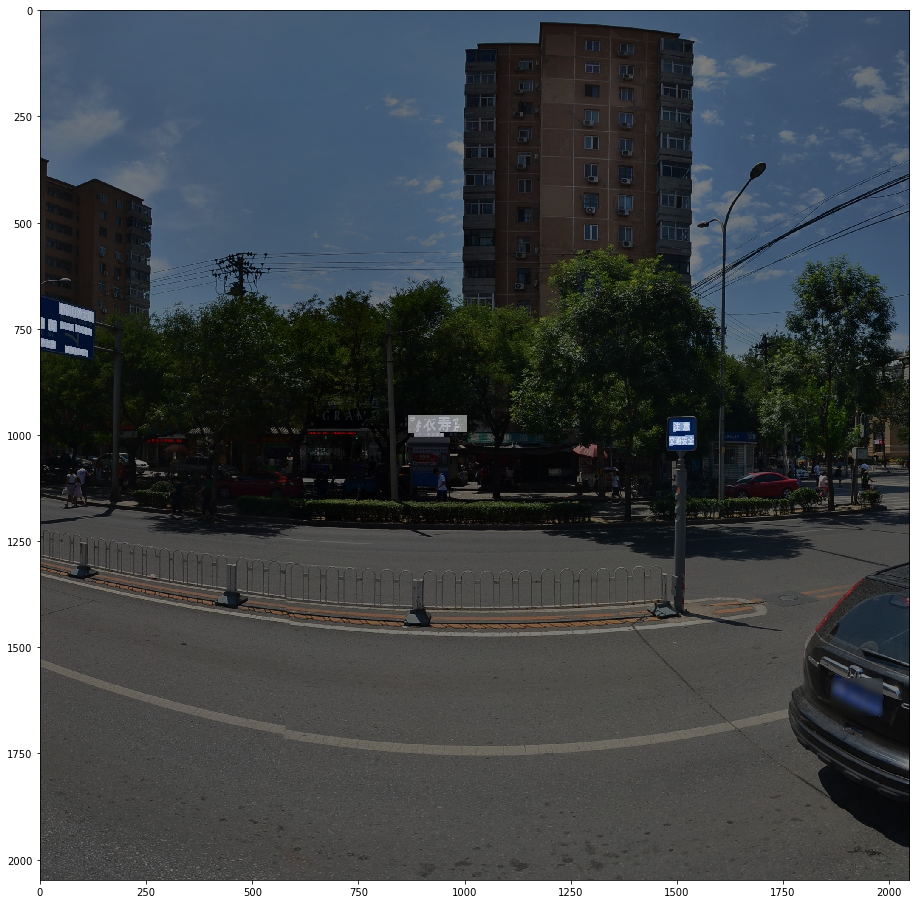

In [30]:
example_img = training_data[3]
example_img_name = example_img['file_name']
print(example_img_name)
plot_char_detection_overlay(example_img, training_gts[example_img_name])

# Part 2 – The models

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

convert_tensor = transforms.ToTensor()

In [20]:
class charDetection(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        

In [21]:
# Credit: https://amaarora.github.io/2020/09/13/unet.html

class charDetectionUNet(nn.Module):

    def __init__(self, height, width):
        super().__init__()
        chan_0 = 3
        chan_1 = 8
        chan_2 = 16
        chan_3 = 32
        self.out_sz = (height, width)

        # Encode Block 1
        self.conv_encode_31 = nn.Conv2d(chan_0, chan_1, 3)
        self.conv_encode_32 = nn.Conv2d(chan_1, chan_1, 3)
        # Encode Block 2
        self.conv_encode_21 = nn.Conv2d(chan_1, chan_2, 3)
        self.conv_encode_22 = nn.Conv2d(chan_2, chan_2, 3)
        # Encode Block 3
        self.conv_encode_11 = nn.Conv2d(chan_2, chan_3, 3)
        self.conv_encode_12 = nn.Conv2d(chan_3, chan_3, 3)
        self.pool = nn.MaxPool2d(2)

        # Decoded Block 1
        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_decode_11 = nn.Conv2d(chan_3*2, chan_2, 3)
        self.conv_decode_12 = nn.Conv2d(chan_2, chan_2, 3)
        # Decoded Block 2
        self.upconv2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_decode_21 = nn.Conv2d(chan_2*2, chan_1, 3)
        self.conv_decode_22 = nn.Conv2d(chan_1, chan_1, 3)
        # Decoded Block 3
        self.upconv3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_decode_31 = nn.Conv2d(chan_1*2, chan_0, 3)
        self.conv_decode_32 = nn.Conv2d(chan_0, chan_0, 3)

        # Final
        self.final_conv = nn.Conv2d(chan_0, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inp):
        # encode
        enc3 = self.conv_encode_32(F.relu(self.conv_encode_31(inp)))
        enc2 = self.pool(enc3)
        enc2 = self.conv_encode_22(F.relu(self.conv_encode_21(enc2)))
        enc1 = self.pool(enc2)
        enc1 = self.conv_encode_12(F.relu(self.conv_encode_11(enc1)))
        enc0 = self.pool(enc1)
        
        # decode + crop and concat
        dec1 = self.upconv1(enc0)
    
        _, _, h, w = dec1.shape
        enc1 = transforms.CenterCrop([h, w])(enc1)
        dec2 = torch.cat([dec1, enc1], dim=1)
        dec2 = self.conv_decode_12(F.relu(self.conv_decode_11(dec2)))
        dec2 = self.upconv2(dec2)
        
        _, _, h, w = dec2.shape
        enc2 = transforms.CenterCrop([h, w])(enc2)
        dec3 = torch.cat([dec2, enc2], dim=1)
        dec3 = self.conv_decode_22(F.relu(self.conv_decode_21(dec3)))
        dec3 = self.upconv3(dec3)

        _, _, h, w = dec3.shape
        enc3 = transforms.CenterCrop([h, w])(enc3)
        dec4 = torch.cat([dec3, enc3], dim=1)
        dec4 = self.conv_decode_32(F.relu(self.conv_decode_31(dec4)))

        out = self.final_conv(dec4)
        out = self.sigmoid(out)
        out = F.interpolate(out, self.out_sz)
        return out

In [23]:

def get_tensor_image(image_data, height, width):
    image = mplplot.imread(IMAGE_DIR + image_data['file_name'])
    rsize = np.resize(image, (height, width,3))
    return convert_tensor(rsize).to(device)

In [24]:
def grid_to_tensor(grid):
    return convert_tensor(grid).unsqueeze(0)

# Part 3 - Testing and evaluation

In [27]:
#device = torch.device('cpu')
device = torch.device('cuda:2')

# Hyper parameters
epochs = 10
learning_rate = 0.01
output_height = IMG_SIZE_ORIG
output_width = IMG_SIZE_ORIG

In [28]:
model = charDetectionUNet(output_height, output_width)
model.to(device)
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model.train()

image_count = len(training_data)

for epoch in range(epochs):
    np.random.shuffle(training_data)
    total_loss = 0
    for i, image in enumerate(training_data):
        tensor_image = get_tensor_image(image, 2048, 2048)
        pred = model(tensor_image.unsqueeze(0))
        truth = grid_to_tensor(training_gts[image['file_name']]).to(device)
        loss = loss_function(pred, truth.float())
        total_loss += loss.item()
        print(f'\rEpoch {epoch+1}/{epochs}, image {i+1}/{image_count}  avg loss: {total_loss/(i+1)}', end='')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print()
    

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/10, image 7/7  avg loss: 0.6283917512212481
Epoch 2/10, image 7/7  avg loss: 0.6043360829353333
Epoch 3/10, image 7/7  avg loss: 0.5814803668430873
Epoch 4/10, image 7/7  avg loss: 0.55954509973526
Epoch 5/10, image 7/7  avg loss: 0.5383086289678302
Epoch 6/10, image 7/7  avg loss: 0.5176043680735997
Epoch 7/10, image 7/7  avg loss: 0.4976291401045663
Epoch 8/10, image 7/7  avg loss: 0.4784155658313206
Epoch 9/10, image 7/7  avg loss: 0.4592153898307255
Epoch 10/10, image 7/7  avg loss: 0.43978490574019297


# Plot images

In [39]:
test_img = training_data[0]
test_img_name = test_img['file_name']
print(test_img_name)
# Många tecken = 0001377.jpg

1002235.jpg


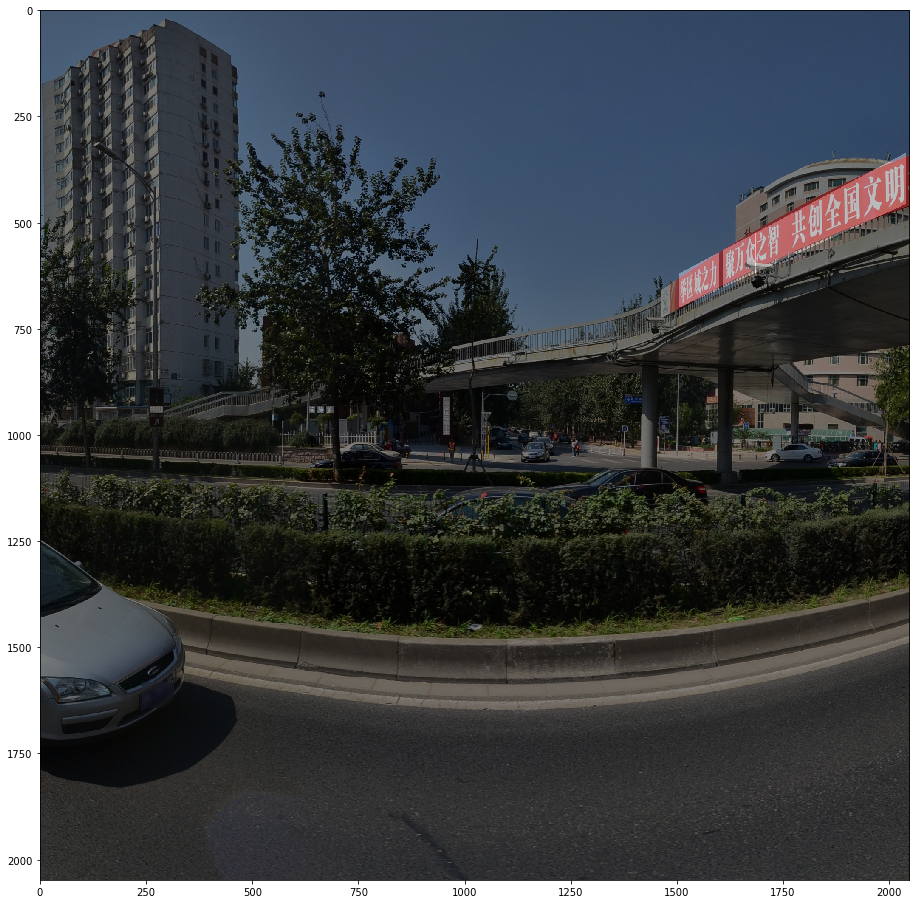

In [40]:
plot_char_detection_overlay(test_img, training_gts[test_img_name])

(2048, 2048)


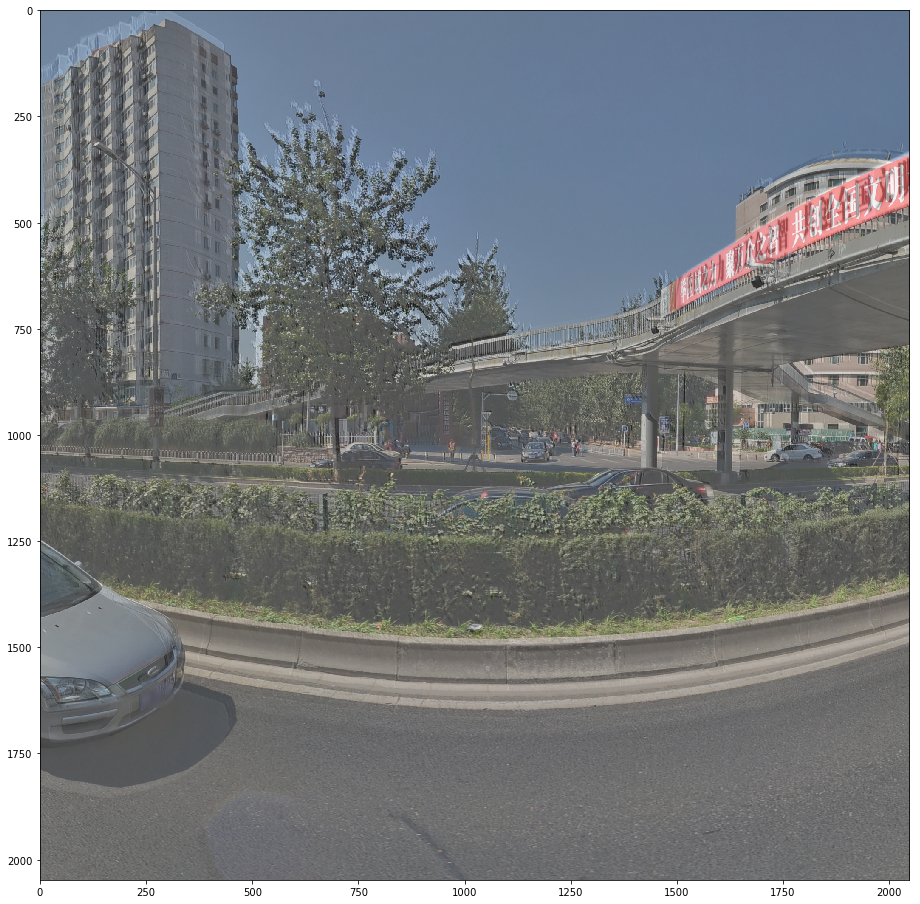

In [41]:
model.eval()
tensor_img = get_tensor_image(test_img, 2048, 2048)
pred = model(tensor_img.unsqueeze(0)).squeeze(0).squeeze()
pred = pred.cpu().detach().numpy()
print(pred.shape)
plot_char_detection_overlay(test_img, pred)

(2048, 2048)


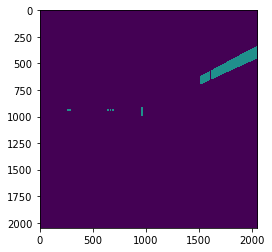

In [42]:
img = training_gts[test_img_name]
print(img.shape)
mplplot.imshow(img)

In [54]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, data, gts):
    model.eval()
    outputs = []

    for i, image in enumerate(data):
        tensor_image = get_tensor_image(image, 2048, 2048)
        with torch.no_grad():
            pred = model(tensor_image.unsqueeze(0))
        pred = pred.squeeze(0).squeeze(0)
        truth = gts[image['file_name']]
        outputs.append((pred.cpu().detach().numpy(), truth))

    # recall/precision/X11/accuracy. Another one is to report it in terms of error, such as mean squared error.
    mse = 0
    for y_pred, y_true in outputs:
        # nn.functional.mse_loss(gen, target)
        loss = mean_squared_error(y_true, y_pred)
        mse += loss
    return outputs


In [55]:
temp = evaluate_model(model, testing_data, testing_gts)

<class 'list'>


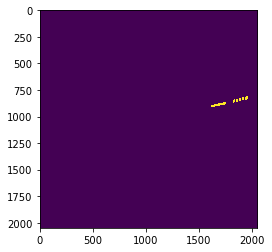

In [56]:
print(type(temp))
img, gt = temp[0]
mplplot.imshow(gt)

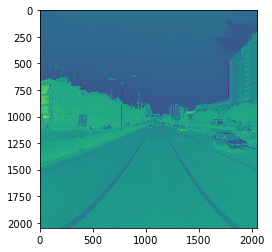

In [57]:
mplplot.imshow(img)